# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jacfwd

# 1.2

In [2]:
# ground truth
X_gt = jnp.array([0.0, 1.0, 2.0, 3.0, 0.0])

# input constraints
Ui = [1.1, 1.0, 1.1, -2.7]
Uij = [0.0]
U = jnp.array([*Ui, *Uij])

# edges of pose graph
odo_edges = [(i, i+1) for i in range(len(Ui))]
loop_edges = [(0, 4)]
edges = [*odo_edges, *loop_edges]

# covariance values
cov_i = [0.01] * len(Ui)
cov_ij = [0.01] * len(Uij)
cov = [*cov_i, *cov_ij, 0.001]
sigma = np.diag(cov)
omega = np.linalg.inv(sigma)
omega = jnp.array(omega)

# 1.3

Refer PDF [q1_3.pdf](q1_3.pdf)

In [3]:
J_analytical = jnp.array([[1, -1, 0, 0, 0], 
                          [0, 1, -1, 0, 0], 
                          [0, 0, 1, -1, 0], 
                          [0, 0, 0, 1, -1],
                          [1, 0, 0, 0, -1], 
                          [1, 0, 0, 0, 0]])

# 1.4

In [4]:
# 1D motion model (vectorized)
# f(xi, ui) = xi + ui
# f(xi, uij) = xi + uij
def motionModel(X, U):
    return X + U

# error function (vectorized)
# eij = f(xi, uij) - xj
def error(X, U, edges):
    start_nodes, end_nodes = [jnp.array(node_list) for node_list in zip(*edges)]
    e = motionModel(X[start_nodes], U) - X[end_nodes]
    return e

In [5]:
# use odometry contraints to find x_init
def getInitialPosesFromOdometry(Ui):
    X = [0.0]
    for u_i in Ui:
        X.append(motionModel(X[-1], u_i))
    return jnp.array(X)

In [6]:
# find objective function f(x)
def findObjectiveFunction(X, U, edges):
    # odometry and loop closure constraints
    f = error(X, U, edges)
    # anchor x0 to origin
    f = jnp.hstack((f, X[0]))
    return f

In [7]:
# find jacobian of f(x)
def findJacobian(X, U, edges):
    f = lambda X : findObjectiveFunction(X, U, edges)
    J = jacfwd(f)
    return J

In [8]:
def plotPoses(X, X_gt):
    plt.plot(X, X, 'r->', label = "Current Poses")
    plt.plot(X, X, 'c-', label = "Constraints")
    plt.plot(X_gt, X_gt, 'ro', label = "Ground Poses")
    plt.legend()
    plt.show()

In [9]:
##### gauss newton formulation
def gaussNewton(input_contraints, omega, num_iter=50):
    X, U, edges = input_contraints    
    J = findJacobian(X, U, edges)
    
    for i in range(num_iter):
        # caluclate f(x) and J(x)
        fx = findObjectiveFunction(X, U, edges)
        Jx = J(X)
        assert(jnp.linalg.norm(Jx - J_analytical, "fro") < 1e-5)
        
        # calculate delta X
        A = Jx.T @ omega @ Jx
        B = -Jx.T @ omega.T @ fx
        del_X = np.linalg.inv(A) @ B

        # update step
        X += del_X
        
        # plot values
        iters.append(i)
        poses.append(X)
        errors.append(0.5 * fx.T @ omega @ fx)
        loop_closure_constraints.append(fx[-2])
        plotPoses(X, X_gt)
        
    return X

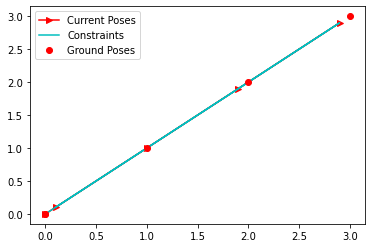

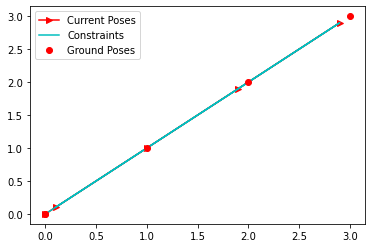

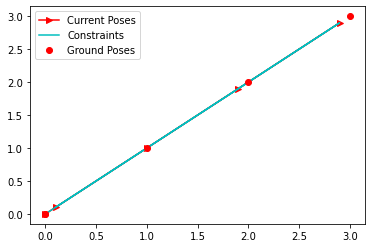

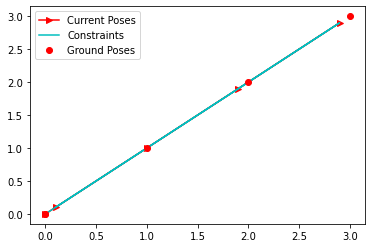

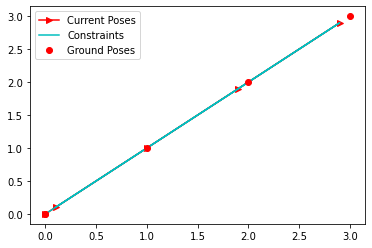

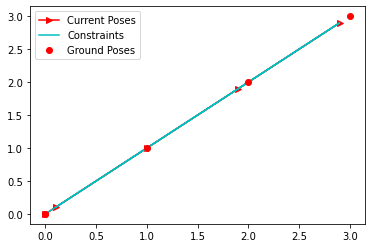

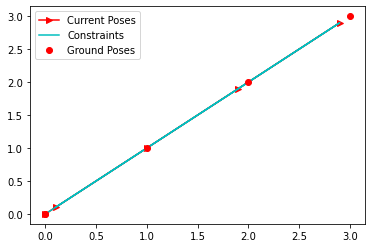

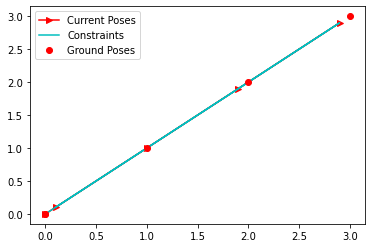

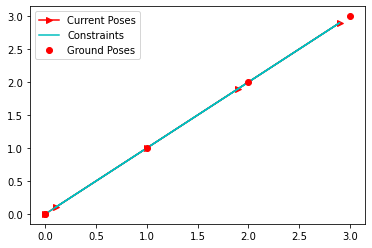

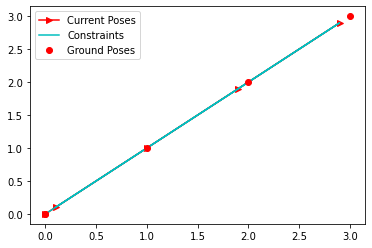

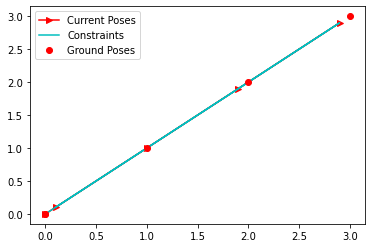

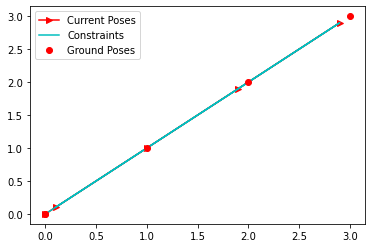

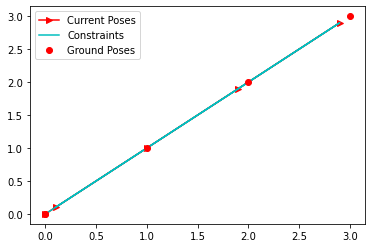

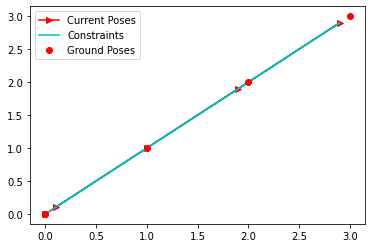

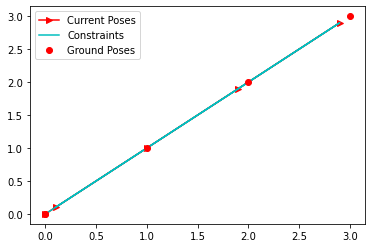

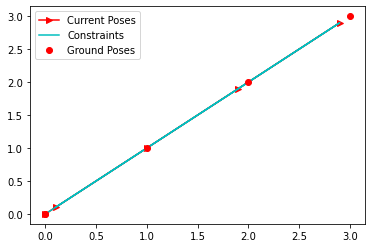

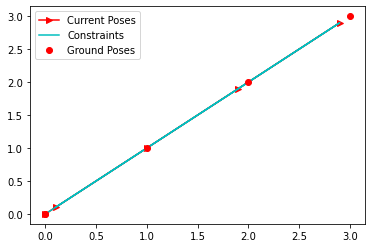

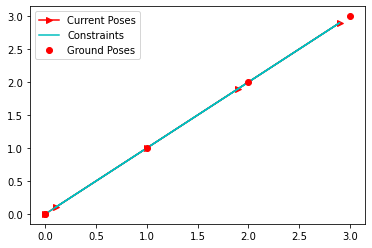

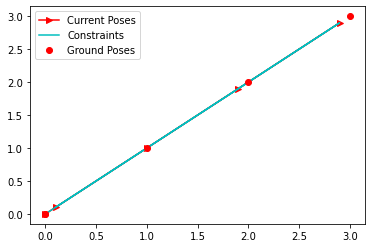

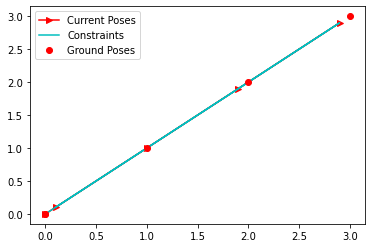

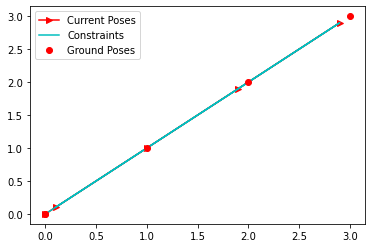

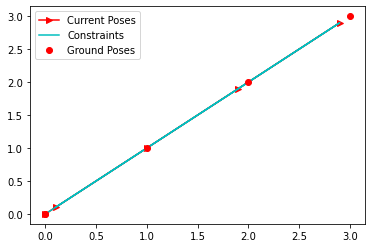

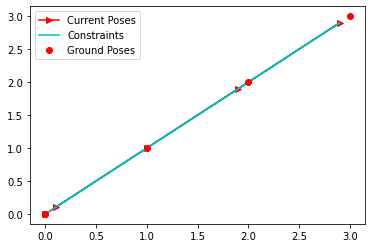

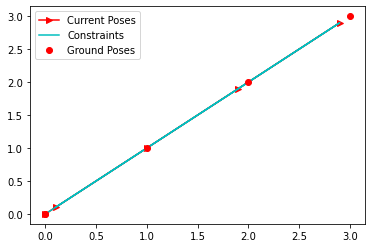

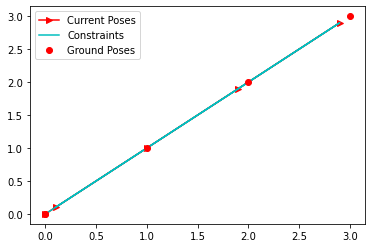

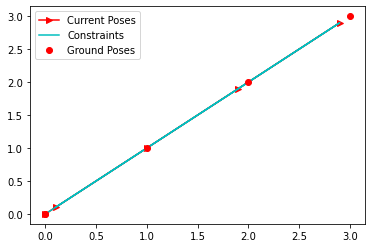

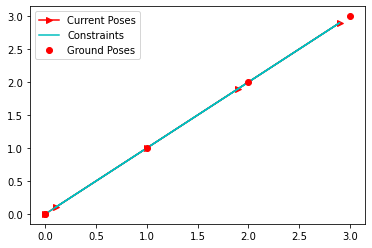

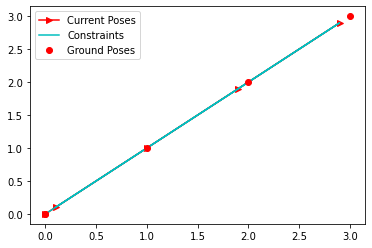

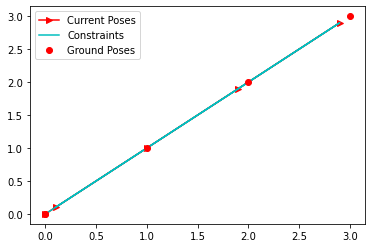

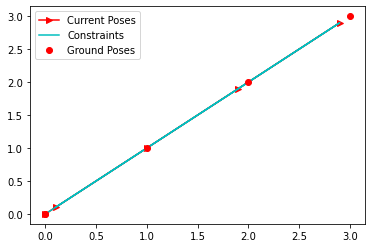

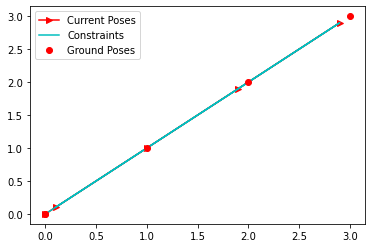

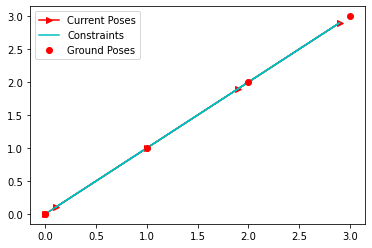

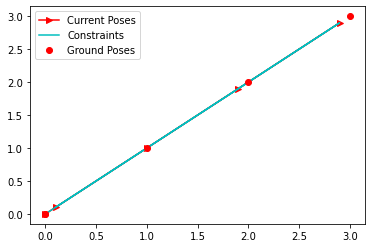

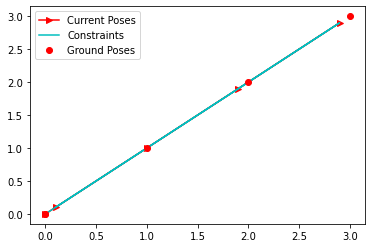

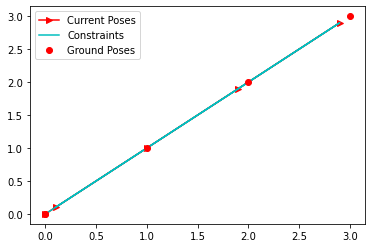

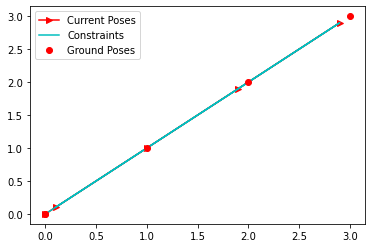

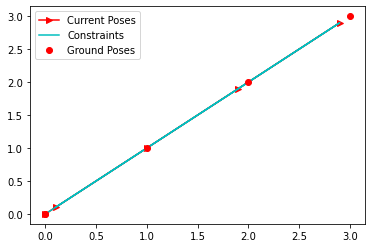

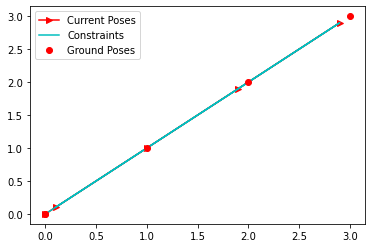

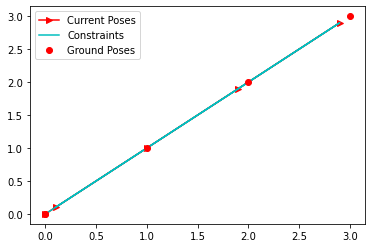

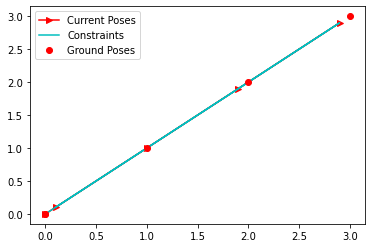

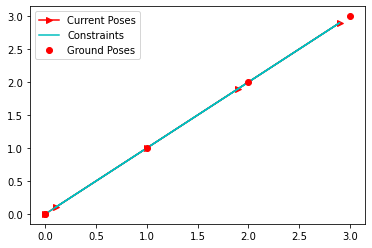

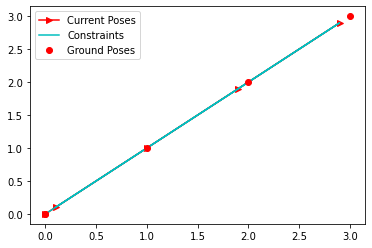

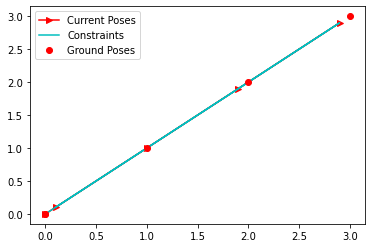

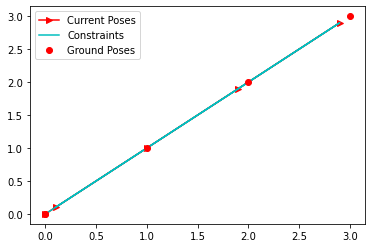

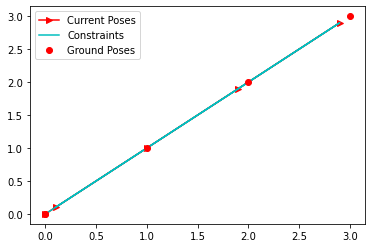

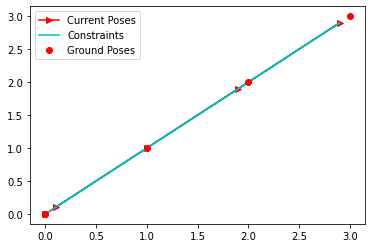

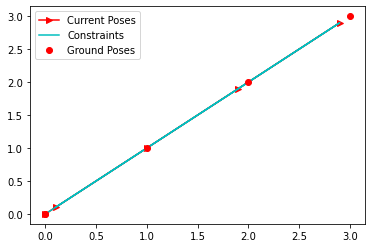

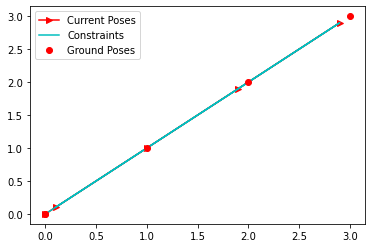

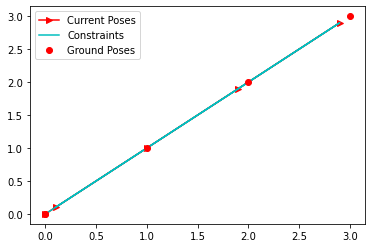

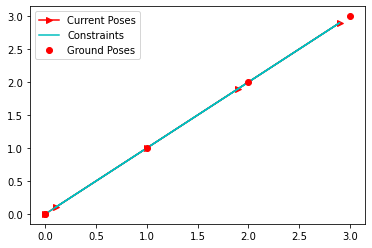

Optimized X: 
 [-3.2782535e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]


In [10]:
# for plotting graphs
iters = []
poses = []
errors = []
loop_closure_constraints = []

# gauss newton formulation
X_init = getInitialPosesFromOdometry(Ui)
X = gaussNewton([X_init, U, edges], omega)
print("Optimized X: \n", X)

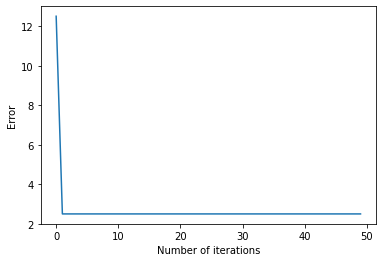

In [11]:
# plot error
plt.plot(iters, errors)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.show()

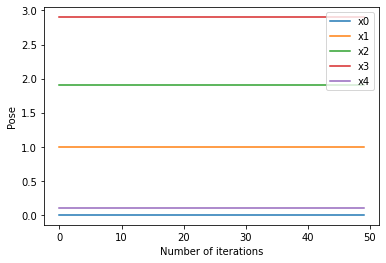

In [12]:
# plot poses
plt.plot(iters, poses)
plt.xlabel("Number of iterations")
plt.ylabel("Pose")
plt.legend([f"x{i}" for i in range(len(X))])
plt.show()